# Depth Space --> Density Space

In [60]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
import argopy

In [27]:
import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df

In [47]:
reload(ff)
reload(ef)
reload(pf)
reload(df)

<module 'density_funcs' from '/home.ufs/amf2288/argo-intern/density_funcs.py'>

In [48]:
s_ds=xr.open_dataset("202206/202206_lon:(25,45)_lat:(-60,-50).nc")
s = ff.get_ds_interp(s_ds,0,2000,4)
s['SPICE'] = gsw.spiciness0(s.SA,s.CT).rename('SPICE')

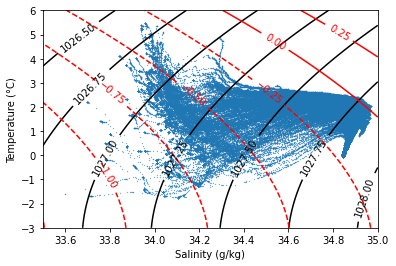

In [49]:
#something is wrong with density here, values look okay except that it should be 26.5-28, not 1026.5-1028
#now that I'm looking, this problem is also present in the function_test notebook, so need to troubleshoot there
#wait it's also in the CCS_poster notebook???? okay I really need to figure this out

ds_li=[s]
Taxis=[-3,6,50]
Saxis=[33.5,35,50]

pf.plot_TS(ds_li, Taxis, Saxis)

In [50]:
rho_grid = np.linspace(26.5,28,1001)

In [51]:
s_rho = df.interpolate2density(s, rho_grid)

50
100
150
200
250
300


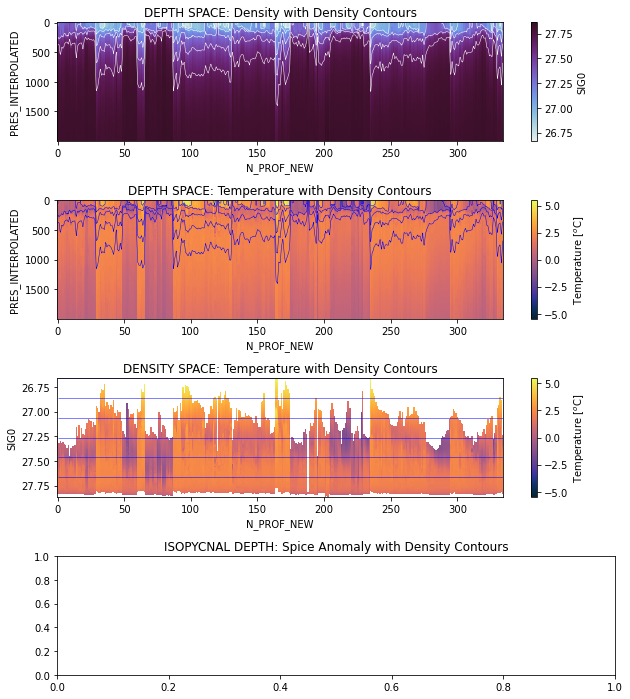

In [52]:
pf.plot_depth_profs(s, s_rho)

## Load Based on Float Profile

Wanted to take a look at a similar analysis as above, but for one float, with a "distance" axis instead of an "N_PROF" axis (more similar to a glider). I think I found the function Dhruv used to create the distance coordinate, interp_distance pasted below, but it also relies on the `glidertools` package, so I can't complete this unfortunately.

In [61]:
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()
argo_loader

<datafetcher.erddap> 'No access point initialised'
Available access points: float, profile, region
Performances: cache=False, parallel=False
User mode: standard
Dataset: phy

In [63]:
float_IDs = np.unique(s.PLATFORM_NUMBER)

In [64]:
float1 = argo_loader.float(float_IDs[0]).to_xarray()

Text(0, 0.5, 'Longitude')

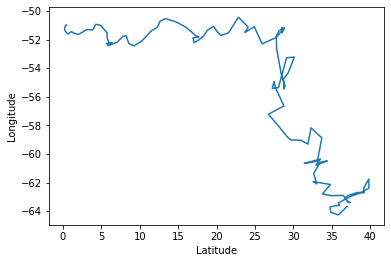

In [66]:
plt.plot(float1.LONGITUDE, float1.LATITUDE)
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [67]:
def interp_distance(ds, var, vert_axis = 'PRES_INTERPOLATED'): 

    #print (ds.longitude.mean(vert_axis))
    distance = np.cumsum(gt.utils.distance(ds.LONGITUDE.mean(vert_axis), 
                                           ds.LATITUDE.mean(vert_axis)))
    
    #print(distance)
    dist_grid = np.arange(0, distance.max(), 500)

    for i in range(len(ds[vert_axis])): 
        
        #ds_temp = ds.isel(ctd_pressure=i) # would be nice if this was indexed without the hard coding
         
        #data = ds_temp[var].values
        
        ds_temp = ds[var][i,:]
        data = ds_temp.values
        
        f = interpolate.interp1d(distance, data, fill_value=np.nan)
        
        var_int = f(dist_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["distance"],
                                 coords={"distance": dist_grid, vert_axis: ds_temp[vert_axis]}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim=vert_axis)
        
    return da_var_int

In [68]:
test=interp_distance(float1, 'N_PROF')

NameError: name 'gt' is not defined